In [1]:
import pandas as pd

In [2]:
csv = 'clean_data.csv'
my_df = pd.read_csv(csv,index_col=0)
my_df.tail()

,text,target
22899,kbrn mataram jumlah penduduk miskin di nusa te...,0
22900,kbrn banda aceh provinsi aceh kembali menjadi ...,0
22901,jakarta kejaksaan agung telah menetapkan direk...,0
22902,menteri kelautan dan perikanan sakti wahyu tre...,1
22903,jakarta pt pegadaian persero yang merupakan ba...,1


In [3]:
# my_df['Value'] = ""

# for i, w in enumerate(my_df['Sentiment']):
#     if w == 'Positive':
#         my_df.at[i, 'Value'] = 1
#     else:
#         my_df.at[i, 'Value'] = 0

In [4]:
# my_df['Value'].value_counts()

In [5]:
my_df.dropna(inplace=True)
my_df.reset_index(drop=True,inplace=True)
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22894 entries, 0 to 22893
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    22894 non-null  object
 1   target  22894 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 357.8+ KB


In [6]:
x = my_df.text
y = my_df.target

In [7]:
from sklearn.model_selection import train_test_split
SEED = 2000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.2, random_state=SEED, stratify=y)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED, stratify=y_validation_and_test)

In [8]:
# stratify is to eliminate bias

In [9]:
print("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_train), (len(x_train[y_train == 0]) / (len(x_train)*1.))*100, (len(x_train[y_train == 1]) / (len(x_train)*1.))*100))
print ("Validation set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_validation), (len(x_validation[y_validation == 0]) / (len(x_validation)*1.))*100, (len(x_validation[y_validation == 1]) / (len(x_validation)*1.))*100))
print("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_test), (len(x_test[y_test == 0]) / (len(x_test)*1.))*100, (len(x_test[y_test == 1]) / (len(x_test)*1.))*100))

Train set has total 18315 entries with 46.77% negative, 53.23% positive
Validation set has total 2289 entries with 46.75% negative, 53.25% positive
Test set has total 2290 entries with 46.77% negative, 53.23% positive


In [10]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from sklearn import utils

In [11]:
def labelize_tweets_ug(tweets,label):
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
        result.append(TaggedDocument(t.split(), [prefix + '_%s' % i]))
    return result

In [12]:
all_x = pd.concat([x_train,x_validation,x_test])
all_x_w2v = labelize_tweets_ug(all_x, 'all')

In [13]:
#all_x_w2v

In [14]:
cores = multiprocessing.cpu_count()
model_ug_cbow = Word2Vec(sg=0, vector_size=100, negative=5, window=2, min_count=1, workers=cores, alpha=0.065, min_alpha=0.065, hs=1)
model_ug_cbow.build_vocab([x.words for x in tqdm(all_x_w2v)])

100%|███████████████████████████████████████████████████████████████████████| 22894/22894 [00:00<00:00, 2869397.75it/s]


In [15]:
%%time
for epoch in range(30):
    model_ug_cbow.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_cbow.alpha -= 0.002
    model_ug_cbow.min_alpha = model_ug_cbow.alpha

100%|███████████████████████████████████████████████████████████████████████| 22894/22894 [00:00<00:00, 3266024.82it/s]


Wall time: 3min 16s


In [16]:
model_ug_sg = Word2Vec(sg=1, vector_size=100, negative=5, window=2, min_count=1, workers=cores, alpha=0.065, min_alpha=0.065, hs=1)
model_ug_sg.build_vocab([x.words for x in tqdm(all_x_w2v)])

100%|███████████████████████████████████████████████████████████████████████| 22894/22894 [00:00<00:00, 2550855.27it/s]


In [17]:
%%time
for epoch in range(30):
    model_ug_sg.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_sg.alpha -= 0.002
    model_ug_sg.min_alpha = model_ug_sg.alpha

100%|███████████████████████████████████████████████████████████████████████| 22894/22894 [00:00<00:00, 3279521.71it/s]


Wall time: 5min 56s


In [18]:
model_ug_cbow.save('w2v_model_ug_cbow.word2vec')
model_ug_sg.save('w2v_model_ug_sg.word2vec')

In [19]:
from gensim.models import KeyedVectors
model_ug_cbow = KeyedVectors.load('w2v_model_ug_cbow.word2vec')
model_ug_sg = KeyedVectors.load('w2v_model_ug_sg.word2vec')

In [20]:
len(model_ug_cbow.wv.index_to_key)

134680

In [21]:
import numpy as np

embeddings_index = {}
for w in model_ug_cbow.wv.index_to_key:
    embeddings_index[w] = np.append(model_ug_cbow.wv[w],model_ug_sg.wv[w])
print('Found %s word vectors.' % len(embeddings_index))

Found 134680 word vectors.


In [22]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=200000) # num_words is the number of vocabularies we want to use
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)

In [23]:
len(tokenizer.word_index)

119613

In [24]:
for x in x_train[:5]:
    print(x)

viva badan penanggulangan bencana daerah bpbd provinsi jawa barat mencatat kejadian bencana alam sepanjang januari tercatat orang meninggal dunia akibat bencana alam yang didominasi akibat cuaca ekstrim manajer pusdalops bpbd provinsi jawa barat budi away budiman menjelaskan pada bencana alam di awal jawa barat tercatat mengalami sembilan kali kebakaran hunian kali bencana angin puting beliung infografis bencana januari di jawa barat tanah longsor kejadian banjir kejadian gelombang pasang tiga kejadian ungkap budi dalam keterangan persnya senin februari akibat kejadian tersebut lanjut budi sebanyak orang terdampak dan orang meninggal dunia berita terkait polisi usut dugaan pungli bantuan umkm di kabupaten bandung tantri kotak hingga ifan seventeen siap gelar konser peduli negeri ridwan kamil ekonomi jawa barat lebih baik dari banten jateng jatim sungai cipunagara meluap ribuan rumah di subang terendam banjir
universitas pertamina bangun ekosistem riset dan inovasi jakarta riset dan ino

In [25]:
sequences[:1]

[[1584,
  242,
  1833,
  661,
  121,
  5099,
  328,
  208,
  324,
  578,
  1769,
  661,
  705,
  352,
  180,
  356,
  80,
  1610,
  131,
  322,
  661,
  705,
  1,
  2107,
  322,
  1752,
  6501,
  2413,
  32935,
  5099,
  328,
  208,
  324,
  801,
  7975,
  4779,
  316,
  9,
  661,
  705,
  3,
  235,
  208,
  324,
  356,
  221,
  2289,
  283,
  3956,
  1684,
  283,
  661,
  2593,
  13006,
  12541,
  3998,
  661,
  180,
  3,
  208,
  324,
  305,
  3217,
  1769,
  416,
  1769,
  2220,
  3957,
  238,
  1769,
  655,
  801,
  8,
  527,
  3891,
  260,
  133,
  322,
  1769,
  18,
  355,
  801,
  195,
  80,
  714,
  2,
  80,
  1610,
  131,
  668,
  120,
  1049,
  11899,
  731,
  14113,
  267,
  149,
  3,
  248,
  798,
  32936,
  6502,
  55,
  41359,
  41360,
  542,
  1958,
  6086,
  2083,
  161,
  1749,
  2644,
  24,
  208,
  324,
  23,
  75,
  7,
  1507,
  2427,
  2440,
  1063,
  36450,
  10352,
  2198,
  98,
  3,
  3854,
  4626,
  416]]

In [26]:
length = []
for x in x_train:
    length.append(len(x.split()))

In [27]:
max(length) # maximum number of words in the sentence

4651

In [28]:
max_len = 4655 # 

In [29]:
x_train_seq = pad_sequences(sequences, maxlen=max_len)
print('Shape of data tensor:', x_train_seq.shape)

Shape of data tensor: (18315, 4655)


In [30]:
x_train_seq[:5]

array([[    0,     0,     0, ...,  3854,  4626,   416],
       [    0,     0,     0, ...,  5350,  8774,  6417],
       [    0,     0,     0, ...,  2026, 13007,    86],
       [    0,     0,     0, ...,  3617,    17,    50],
       [    0,     0,     0, ...,    86,  9687, 23554]])

In [31]:
sequences_val = tokenizer.texts_to_sequences(x_validation)
x_val_seq = pad_sequences(sequences_val, maxlen=max_len)

In [32]:
num_words = 200000
embedding_matrix = np.zeros((num_words, 200))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [33]:
np.array_equal(embedding_matrix[29] ,embeddings_index.get('good'))

False

In [34]:
seed = 7

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

In [31]:
#Skip this part next time

In [32]:
model_ptw2v = Sequential()
e = Embedding(num_words, 200, weights=[embedding_matrix], input_length=max_len, trainable=False)
model_ptw2v.add(e)
model_ptw2v.add(Flatten())
model_ptw2v.add(Dense(256, activation='relu'))
model_ptw2v.add(Dense(1, activation='sigmoid'))
model_ptw2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ptw2v.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
702/702 - 654s - loss: 0.4868 - accuracy: 0.7730 - val_loss: 0.3990 - val_accuracy: 0.8079
Epoch 2/5
702/702 - 658s - loss: 0.1960 - accuracy: 0.9161 - val_loss: 0.4699 - val_accuracy: 0.7817
Epoch 3/5
702/702 - 666s - loss: 0.0502 - accuracy: 0.9891 - val_loss: 0.6426 - val_accuracy: 0.8035
Epoch 4/5
702/702 - 655s - loss: 0.0109 - accuracy: 0.9982 - val_loss: 0.7454 - val_accuracy: 0.8079
Epoch 5/5
702/702 - 654s - loss: 0.0048 - accuracy: 0.9996 - val_loss: 0.8488 - val_accuracy: 0.8079


In [33]:
model_ptw2v = Sequential()
e = Embedding(num_words, 200, input_length=max_len)
model_ptw2v.add(e)
model_ptw2v.add(Flatten())
model_ptw2v.add(Dense(256, activation='relu'))
model_ptw2v.add(Dense(1, activation='sigmoid'))
model_ptw2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ptw2v.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
702/702 - 1183s - loss: 0.8303 - accuracy: 0.7978 - val_loss: 0.3369 - val_accuracy: 0.8559
Epoch 2/5
702/702 - 1139s - loss: 0.0348 - accuracy: 0.9884 - val_loss: 0.4422 - val_accuracy: 0.8734
Epoch 3/5
702/702 - 1326s - loss: 0.0053 - accuracy: 0.9991 - val_loss: 0.5226 - val_accuracy: 0.8603
Epoch 4/5
702/702 - 1160s - loss: 0.0031 - accuracy: 0.9997 - val_loss: 0.4528 - val_accuracy: 0.8734
Epoch 5/5
702/702 - 1170s - loss: 5.7384e-04 - accuracy: 1.0000 - val_loss: 0.5206 - val_accuracy: 0.8690


In [34]:
model_ptw2v = Sequential()
e = Embedding(num_words, 200, weights=[embedding_matrix], input_length=max_len, trainable=True)
model_ptw2v.add(e)
model_ptw2v.add(Flatten())
model_ptw2v.add(Dense(256, activation='relu'))
model_ptw2v.add(Dense(1, activation='sigmoid'))
model_ptw2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ptw2v.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
702/702 - 1213s - loss: 0.4906 - accuracy: 0.7806 - val_loss: 0.4161 - val_accuracy: 0.8079
Epoch 2/5
702/702 - 1203s - loss: 0.1534 - accuracy: 0.9429 - val_loss: 0.5229 - val_accuracy: 0.8122
Epoch 3/5
702/702 - 1003s - loss: 0.0167 - accuracy: 0.9951 - val_loss: 0.5684 - val_accuracy: 0.8341
Epoch 4/5
702/702 - 949s - loss: 0.0041 - accuracy: 0.9996 - val_loss: 0.6515 - val_accuracy: 0.8384
Epoch 5/5
702/702 - 949s - loss: 0.0022 - accuracy: 0.9999 - val_loss: 0.6618 - val_accuracy: 0.8341


In [35]:
from keras.layers import Conv1D, GlobalMaxPooling1D

In [36]:
structure_test = Sequential()
e = Embedding(num_words, 200, input_length=max_len)
structure_test.add(e)
structure_test.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
structure_test.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 4655, 200)         40000000  
_________________________________________________________________
conv1d (Conv1D)              (None, 4654, 100)         40100     
Total params: 40,040,100
Trainable params: 40,040,100
Non-trainable params: 0
_________________________________________________________________


In [37]:
structure_test = Sequential()
e = Embedding(num_words, 200, input_length=max_len)
structure_test.add(e)
structure_test.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
structure_test.add(GlobalMaxPooling1D())
structure_test.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 4655, 200)         40000000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4654, 100)         40100     
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
Total params: 40,040,100
Trainable params: 40,040,100
Non-trainable params: 0
_________________________________________________________________


In [38]:
model_cnn_01 = Sequential()
e = Embedding(num_words, 200, weights=[embedding_matrix], input_length=max_len, trainable=False)
model_cnn_01.add(e)
model_cnn_01.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
model_cnn_01.add(GlobalMaxPooling1D())
model_cnn_01.add(Dense(256, activation='relu'))
model_cnn_01.add(Dense(1, activation='sigmoid'))
model_cnn_01.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn_01.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
573/573 - 138s - loss: 0.4966 - accuracy: 0.7458 - val_loss: 0.4115 - val_accuracy: 0.8104
Epoch 2/5
573/573 - 126s - loss: 0.3492 - accuracy: 0.8434 - val_loss: 0.4446 - val_accuracy: 0.7899
Epoch 3/5
573/573 - 128s - loss: 0.2728 - accuracy: 0.8835 - val_loss: 0.3982 - val_accuracy: 0.8244
Epoch 4/5
573/573 - 121s - loss: 0.2161 - accuracy: 0.9099 - val_loss: 0.4273 - val_accuracy: 0.8296
Epoch 5/5
573/573 - 113s - loss: 0.1490 - accuracy: 0.9406 - val_loss: 0.4964 - val_accuracy: 0.8196


In [39]:
model_cnn_02 = Sequential()
e = Embedding(num_words, 200, input_length=max_len)
model_cnn_02.add(e)
model_cnn_02.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
model_cnn_02.add(GlobalMaxPooling1D())
model_cnn_02.add(Dense(256, activation='relu'))
model_cnn_02.add(Dense(1, activation='sigmoid'))
model_cnn_02.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn_02.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
573/573 - 350s - loss: 0.3980 - accuracy: 0.8115 - val_loss: 0.3445 - val_accuracy: 0.8388
Epoch 2/5
573/573 - 366s - loss: 0.1959 - accuracy: 0.9190 - val_loss: 0.3629 - val_accuracy: 0.8471
Epoch 3/5
573/573 - 359s - loss: 0.0671 - accuracy: 0.9775 - val_loss: 0.4371 - val_accuracy: 0.8580
Epoch 4/5
573/573 - 367s - loss: 0.0376 - accuracy: 0.9895 - val_loss: 0.4900 - val_accuracy: 0.8571
Epoch 5/5
573/573 - 347s - loss: 0.0224 - accuracy: 0.9945 - val_loss: 0.5500 - val_accuracy: 0.8598


In [40]:
from keras.layers import Input, Dense, concatenate, Activation
from keras.models import Model

art_input = Input(shape=(max_len,), dtype='int32')

art_encoder = Embedding(num_words, 200, input_length=max_len)(art_input)
bigram_branch = Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1)(art_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='valid', activation='relu', strides=1)(art_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=100, kernel_size=4, padding='valid', activation='relu', strides=1)(art_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dense(256, activation='relu')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(1)(merged)
output = Activation('sigmoid')(merged)
model_test = Model(inputs=[art_input], outputs=[output])
model_test.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model_test.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4655)]       0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 4655, 200)    40000000    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 4654, 100)    40100       embedding_4[0][0]                
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 4653, 100)    60100       embedding_4[0][0]                
______________________________________________________________________________________________

In [41]:
from keras.callbacks import ModelCheckpoint

filepath="Train_best_weights.{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

model_test.fit(x_train_seq, y_train, batch_size=32, epochs=5,
                     validation_data=(x_val_seq, y_validation), callbacks = [checkpoint])

Epoch 1/5
573/573 [==============================] - 712s 1s/step - loss: 0.4848 - accuracy: 0.7412 - val_loss: 0.3379 - val_accuracy: 0.8401

Epoch 00001: val_accuracy improved from -inf to 0.84010, saving model to Train_best_weights.01-0.8401.hdf5
Epoch 2/5
573/573 [==============================] - 713s 1s/step - loss: 0.1644 - accuracy: 0.9384 - val_loss: 0.3008 - val_accuracy: 0.8777

Epoch 00002: val_accuracy improved from 0.84010 to 0.87768, saving model to Train_best_weights.02-0.8777.hdf5
Epoch 3/5
573/573 [==============================] - 753s 1s/step - loss: 0.0535 - accuracy: 0.9851 - val_loss: 0.4138 - val_accuracy: 0.8641

Epoch 00003: val_accuracy did not improve from 0.87768
Epoch 4/5
573/573 [==============================] - 782s 1s/step - loss: 0.0294 - accuracy: 0.9935 - val_loss: 0.4007 - val_accuracy: 0.8737

Epoch 00004: val_accuracy did not improve from 0.87768
Epoch 5/5
573/573 [==============================] - 762s 1s/step - loss: 0.0157 - accuracy: 0.9962 -

In [42]:
# create checkpoint to test

In [43]:
model_cnn_03 = Sequential()
e = Embedding(num_words, 200, weights=[embedding_matrix], input_length=max_len, trainable=True)
model_cnn_03.add(e)
model_cnn_03.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
model_cnn_03.add(GlobalMaxPooling1D())
model_cnn_03.add(Dense(256, activation='relu'))
model_cnn_03.add(Dense(1, activation='sigmoid'))
model_cnn_03.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn_03.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
573/573 - 322s - loss: 0.4740 - accuracy: 0.7607 - val_loss: 0.3810 - val_accuracy: 0.8239
Epoch 2/5
573/573 - 320s - loss: 0.2623 - accuracy: 0.8909 - val_loss: 0.3755 - val_accuracy: 0.8261
Epoch 3/5
573/573 - 321s - loss: 0.1222 - accuracy: 0.9552 - val_loss: 0.4061 - val_accuracy: 0.8405
Epoch 4/5
573/573 - 321s - loss: 0.0554 - accuracy: 0.9823 - val_loss: 0.4816 - val_accuracy: 0.8488
Epoch 5/5
573/573 - 320s - loss: 0.0407 - accuracy: 0.9890 - val_loss: 0.6038 - val_accuracy: 0.8327


In [44]:
from keras.layers import Input, Dense, concatenate, Activation
from keras.models import Model

tweet_input = Input(shape=(max_len,), dtype='int32')

tweet_encoder = Embedding(num_words, 200, weights=[embedding_matrix], input_length=max_len, trainable=True)(tweet_input)
bigram_branch = Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1)(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='valid', activation='relu', strides=1)(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=100, kernel_size=4, padding='valid', activation='relu', strides=1)(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dense(256, activation='relu')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(1)(merged)
output = Activation('sigmoid')(merged)
model = Model(inputs=[tweet_input], outputs=[output])
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 4655)]       0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 4655, 200)    40000000    input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 4654, 100)    40100       embedding_6[0][0]                
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 4653, 100)    60100       embedding_6[0][0]                
____________________________________________________________________________________________

In [45]:
from keras.callbacks import ModelCheckpoint

filepath="CNN_best_weights.{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

model.fit(x_train_seq, y_train, batch_size=32, epochs=5,
                     validation_data=(x_val_seq, y_validation), callbacks = [checkpoint])

Epoch 1/5
573/573 [==============================] - 708s 1s/step - loss: 0.6707 - accuracy: 0.6715 - val_loss: 0.3616 - val_accuracy: 0.8327

Epoch 00001: val_accuracy improved from -inf to 0.83268, saving model to CNN_best_weights.01-0.8327.hdf5
Epoch 2/5
573/573 [==============================] - 687s 1s/step - loss: 0.2740 - accuracy: 0.8878 - val_loss: 0.3315 - val_accuracy: 0.8506

Epoch 00002: val_accuracy improved from 0.83268 to 0.85059, saving model to CNN_best_weights.02-0.8506.hdf5
Epoch 3/5
573/573 [==============================] - 704s 1s/step - loss: 0.1244 - accuracy: 0.9578 - val_loss: 0.3571 - val_accuracy: 0.8550

Epoch 00003: val_accuracy improved from 0.85059 to 0.85496, saving model to CNN_best_weights.03-0.8550.hdf5
Epoch 4/5
573/573 [==============================] - 705s 1s/step - loss: 0.0607 - accuracy: 0.9802 - val_loss: 0.4334 - val_accuracy: 0.8550

Epoch 00004: val_accuracy did not improve from 0.85496
Epoch 5/5
573/573 [==============================] -

In [59]:
from keras.models import load_model
loaded_CNN_model = load_model('CNN_best_weights.03-0.8550.hdf5')
loaded_CNN_model.evaluate(x=x_val_seq, y=y_validation)

72/72 [==============================] - 16s 223ms/step - loss: 0.3571 - accuracy: 0.8550


[0.3570740222930908, 0.8549584746360779]

In [60]:
from keras.models import load_model
train_model = load_model('Train_best_weights.02-0.8777.hdf5')
train_model.evaluate(x=x_val_seq, y=y_validation)

72/72 [==============================] - 17s 234ms/step - loss: 0.3008 - accuracy: 0.8777


[0.30083000659942627, 0.8776758313179016]

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer(max_features=num_words,ngram_range=(1, 3))
tvec.fit(x_train)

TfidfVectorizer(max_features=200000, ngram_range=(1, 3))

In [62]:
x_train_tfidf = tvec.transform(x_train)
x_test_tfidf = tvec.transform(x_test)

In [63]:
import sklearn.linear_model as sk

lr_with_tfidf = sk.LogisticRegression(solver='lbfgs', max_iter=1000)
lr_with_tfidf.fit(x_train_tfidf,y_train)

LogisticRegression(max_iter=1000)

In [64]:
lr_with_tfidf.score(x_test_tfidf,y_test)

0.8231441048034934

In [65]:
yhat_lr = lr_with_tfidf.predict_proba(x_test_tfidf)

In [66]:
sequences_test = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(sequences_test, maxlen=max_len)

In [67]:
loaded_CNN_model.evaluate(x=x_test_seq, y=y_test)

72/72 [==============================] - 17s 235ms/step - loss: 0.3616 - accuracy: 0.8541


[0.3616117238998413, 0.8541484475135803]

In [68]:
train_model.evaluate(x=x_test_seq, y=y_test)

72/72 [==============================] - 18s 251ms/step - loss: 0.2643 - accuracy: 0.8869


[0.26428934931755066, 0.8868995904922485]

In [69]:
yhat_cnn = loaded_CNN_model.predict(x_test_seq)

In [70]:
yhat_train = train_model.predict(x_test_seq)

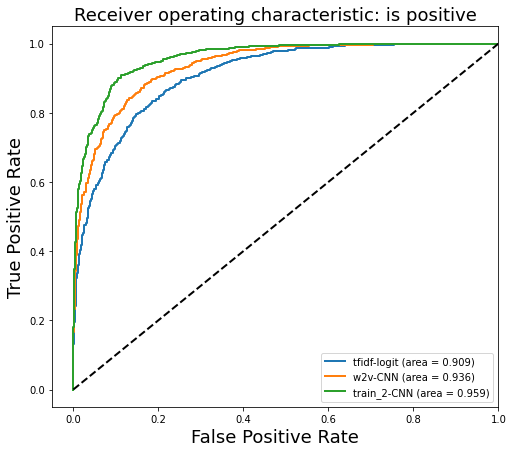

In [71]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(y_test, yhat_lr[:,1])
roc_auc = auc(fpr, tpr)

fpr_cnn, tpr_cnn, threshold = roc_curve(y_test, yhat_cnn)
roc_auc_nn = auc(fpr_cnn, tpr_cnn)

fpr_train, tpr_train, threshold = roc_curve(y_test, yhat_train)
roc_auc_train = auc(fpr_train, tpr_train)

plt.figure(figsize=(8,7))
plt.plot(fpr, tpr, label='tfidf-logit (area = %0.3f)' % roc_auc, linewidth=2)
plt.plot(fpr_cnn, tpr_cnn, label='w2v-CNN (area = %0.3f)' % roc_auc_nn, linewidth=2)
plt.plot(fpr_train, tpr_train, label='train_2-CNN (area = %0.3f)' % roc_auc_train, linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic: is positive', fontsize=18)
plt.legend(loc="lower right")
plt.show()